In [22]:
import pandas as pd
import numpy as np
import os

In [23]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
bach = 32

## File Handling

### Train Set

In [24]:
files_dog = os.listdir("dataset/training_set/dogs")
files_cat = os.listdir("dataset/training_set/cats")

In [25]:
df_dog = pd.DataFrame({
    'filename': files_dog
})

df_dog.drop([0], inplace = True)
df_dog['category'] = 'Dog'
df_dog['filename'] = df_dog['filename'].apply(lambda a: 'dogs/'+a)
df_dog.head()

,filename,category
1,dogs/dog.1.jpg,Dog
2,dogs/dog.10.jpg,Dog
3,dogs/dog.100.jpg,Dog
4,dogs/dog.1000.jpg,Dog
5,dogs/dog.1001.jpg,Dog


In [26]:
df_cat = pd.DataFrame({
    'filename': files_cat
})

df_cat.drop([0], inplace = True)
df_cat['category'] = 'Cat'
df_cat['filename'] = df_cat['filename'].apply(lambda a: 'cats/'+a)
df_cat.head()

,filename,category
1,cats/cat.1.jpg,Cat
2,cats/cat.10.jpg,Cat
3,cats/cat.100.jpg,Cat
4,cats/cat.1000.jpg,Cat
5,cats/cat.1001.jpg,Cat


In [27]:
df_train = pd.concat([df_dog,df_cat])
df_train

,filename,category
1,dogs/dog.1.jpg,Dog
2,dogs/dog.10.jpg,Dog
3,dogs/dog.100.jpg,Dog
4,dogs/dog.1000.jpg,Dog
5,dogs/dog.1001.jpg,Dog
...,...,...
3996,cats/cat.995.jpg,Cat
3997,cats/cat.996.jpg,Cat
3998,cats/cat.997.jpg,Cat
3999,cats/cat.998.jpg,Cat


### Test Set

In [28]:
files_dog = os.listdir("dataset/test_set/dogs")
files_cat = os.listdir("dataset/test_set/cats")

In [29]:
df_dog = pd.DataFrame({
    'filename': files_dog
})

df_dog.drop([0], inplace = True)
df_dog['category'] = 'Dog'
df_dog['filename'] = df_dog['filename'].apply(lambda a: 'dogs/'+a)


df_cat = pd.DataFrame({
    'filename': files_cat
})

df_cat.drop([0], inplace = True)
df_cat['category'] = 'Cat'
df_cat['filename'] = df_cat['filename'].apply(lambda a: 'cats/'+a)

df_test = pd.concat([df_dog,df_cat])
df_test


,filename,category
1,dogs/dog.4001.jpg,Dog
2,dogs/dog.4002.jpg,Dog
3,dogs/dog.4003.jpg,Dog
4,dogs/dog.4004.jpg,Dog
5,dogs/dog.4005.jpg,Dog
...,...,...
996,cats/cat.4996.jpg,Cat
997,cats/cat.4997.jpg,Cat
998,cats/cat.4998.jpg,Cat
999,cats/cat.4999.jpg,Cat


## Image Preprocessing

In [30]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

Lets select a random image as an example

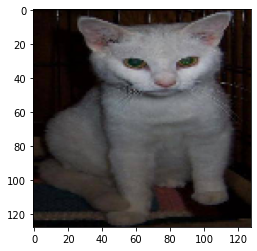

In [31]:
sample = randint(0,len(df_train)-1)

image = load_img("dataset/training_set/"+df_train['filename'].iloc[sample], target_size= IMAGE_SIZE)
plt.imshow(image)
plt.show()

### Training Generator

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "dataset/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=bach
)

Found 8000 validated image filenames belonging to 2 classes.


### Testing Generator

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    "dataset/test_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=bach
)

Found 2000 validated image filenames belonging to 2 classes.


### Preprocesses image example:

Lets apply the transformations on the example image we saw earlier

In [34]:
example_df = df_train.reset_index(drop = True).iloc[sample]
example_df = pd.DataFrame(example_df).T.reset_index(drop = True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "dataset/training_set/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


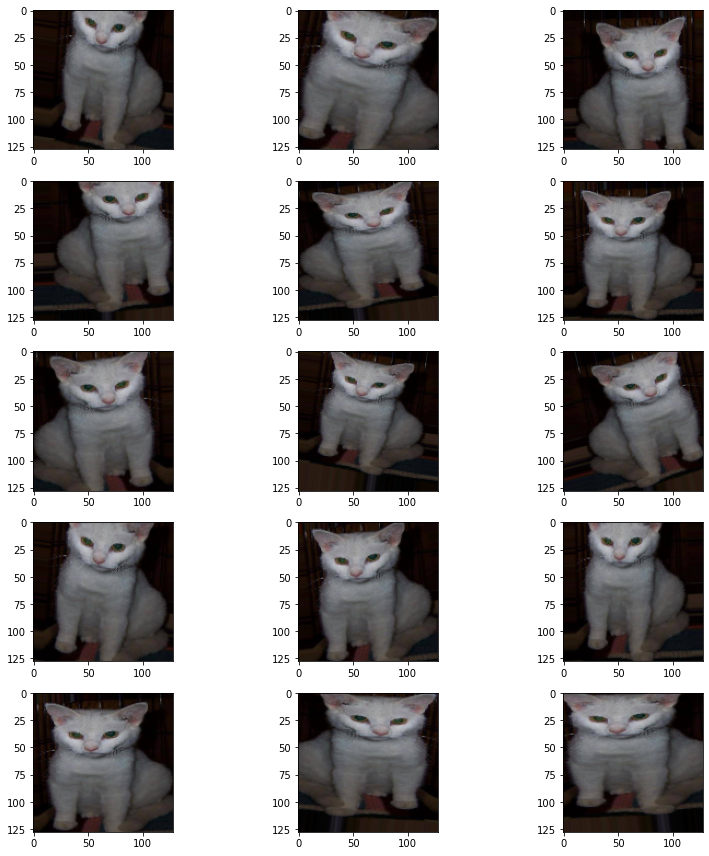

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

looks nice!

## CNN Model

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [37]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)       

## Callbacks and Overfitting

In [38]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [39]:
earlystop = EarlyStopping(patience=10)

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [41]:
callbacks = [earlystop, learning_rate_reduction]

## Fitting the data

In [42]:
epochs=30
history = cnn.fit(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=df_test.shape[0]//bach,
    steps_per_epoch=df_train.shape[0]//bach,
    callbacks=callbacks
)

Epoch 1/30
250/250 [==============================] - 97s 387ms/step - loss: 0.0000e+00 - accuracy: 0.4997 - val_loss: 0.0000e+00 - val_accuracy: 0.4995
Epoch 2/30
250/250 [==============================] - 25713s 103s/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5005
Epoch 3/30
250/250 [==============================] - 185s 740ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5010
Epoch 4/30
250/250 [==============================] - 143s 573ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5005
Epoch 5/30
250/250 [==============================] - 103s 412ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5005
Epoch 6/30
250/250 [==============================] - 86s 344ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/30
250/250 [==============================] - 88s 351ms/step - loss: 

KeyboardInterrupt: 

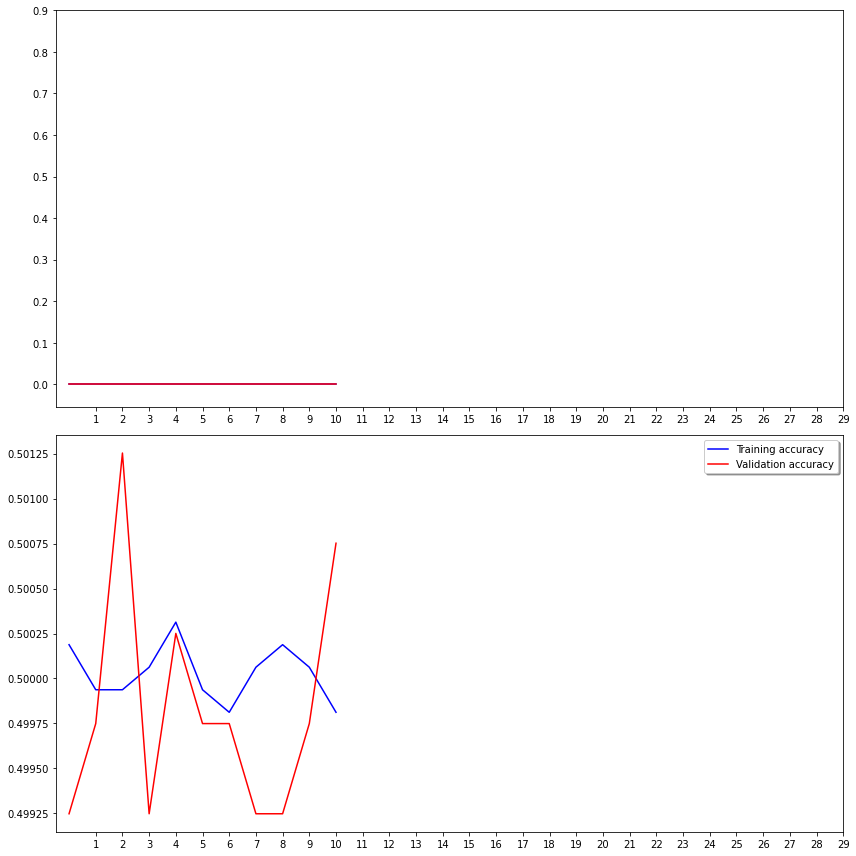

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [54]:
pred = cnn.predict(test_generator)

In [55]:
print(len(pred))

2000


In [49]:
for i in range(len(pred)):
    if pred[i][0] >= pred[i][1]:
        pred[i][0] = 1
        pred[i][1] = 0
    else:
        pred[i][0] = 0
        pred[i][1] = 1
pred

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [28]:
print(len(pred))

2000


In [29]:
df2 = np.asanyarray(pd.get_dummies(df_test['category']))
df2 = df2[:,0]
df2
pred = pred[:,0]

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
print(classification_report(df2,pred))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47      1000
           1       0.51      0.57      0.54      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000



In [32]:
print(confusion_matrix(df2,pred))

[[442 558]
 [430 570]]


In [33]:
summ = abs(df2[0] - pred[0])

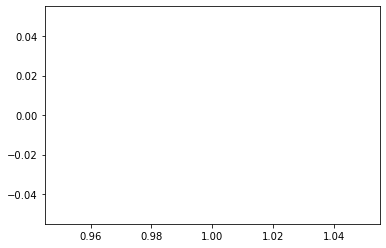

In [34]:
plt.plot(pred[0],df2[0])

In [50]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image/255.0)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

ValueError: in user code:

    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\shrey\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\shrey\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\shrey\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\shrey\anaconda3\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 28800 but received input with shape (None, 6272)


In [53]:
c = 0
for X,Y in test_generator:
    c+=1
    print(c)
c

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


KeyboardInterrupt: 

In [56]:
scores = cnn.evaluate(test_generator)

134/134 [==============================] - 7s 48ms/step - loss: 0.4479 - accuracy: 0.7940


In [81]:
pred_ex = cnn.predict(example_generator)

In [82]:
print(pred_ex)

[[0.2971134  0.70288664]]


In [83]:
train_generator.class_indices

{'Cat': 0, 'Dog': 1}